In [2]:
import sys
sys.path.append("/Users/pankajti/dev/git/fedreserve_data_research")

In [3]:
import pandas as pd
from pandas_datareader import data as pdr
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from frdr.database.connections import engine,session

# Set date range (Powell: 2018–2025)
start_date = '2006-01-01'
end_date = '2025-05-12'

# 1. Fetch External Data
# Override pandas-datareader to use FRED
import pandas_datareader.data as web
web.DataReader = pdr.DataReader

# 10-Year Treasury Yield (FRED: DGS10)
treasury_yield = web.DataReader('DGS10', 'fred', start_date, end_date)
treasury_yield = treasury_yield.rename(columns={'DGS10': 'Yield'})

# Federal Funds Rate (FRED: DFF)
ffr = web.DataReader('DFF', 'fred', start_date, end_date)
ffr = ffr.rename(columns={'DFF': 'FedFundsRate'})

Plots 'yields_vs_ffr_timeseries.png' and 'yields_vs_ffr_scatter.png' have been generated.
Merged data saved to 'treasury_yield_and_ffr.csv'.


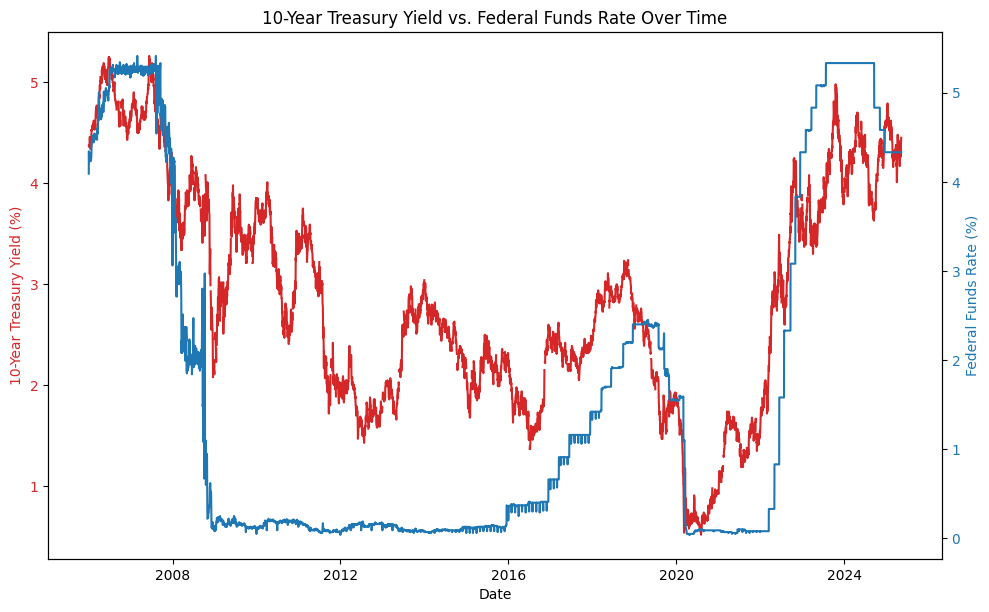

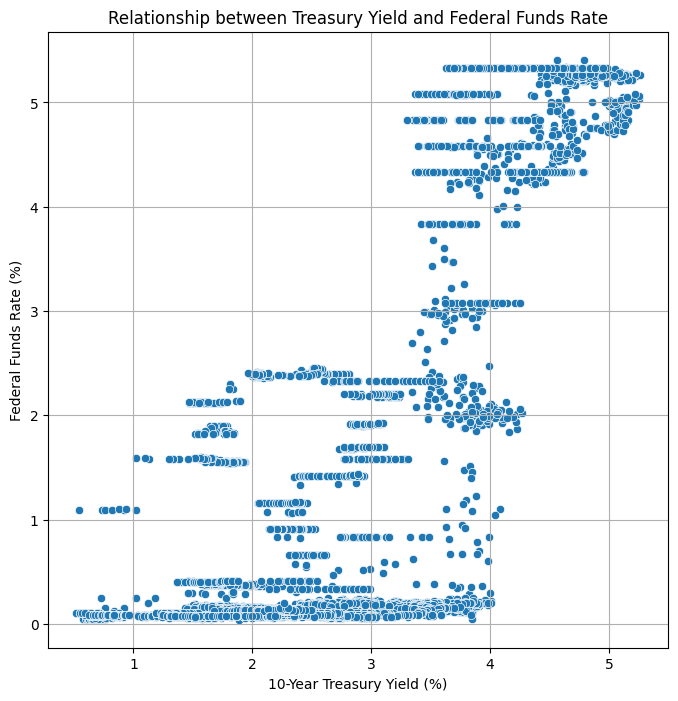

In [4]:
# Merging the two dataframes
data = pd.merge(treasury_yield, ffr, left_index=True, right_index=True)

# 2. Visualize the Data
# Time-series plot with two y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('10-Year Treasury Yield (%)', color=color)
ax1.plot(data.index, data['Yield'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Federal Funds Rate (%)', color=color)
ax2.plot(data.index, data['FedFundsRate'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('10-Year Treasury Yield vs. Federal Funds Rate Over Time')
plt.savefig('yields_vs_ffr_timeseries.png')

# Scatter plot to show the relationship directly
plt.figure(figsize=(8, 8))
sns.scatterplot(x='Yield', y='FedFundsRate', data=data)
plt.title('Relationship between Treasury Yield and Federal Funds Rate')
plt.xlabel('10-Year Treasury Yield (%)')
plt.ylabel('Federal Funds Rate (%)')
plt.grid(True)
plt.savefig('yields_vs_ffr_scatter.png')

# 3. Save the merged data to a CSV file
data.to_csv('treasury_yield_and_ffr.csv')
print("Plots 'yields_vs_ffr_timeseries.png' and 'yields_vs_ffr_scatter.png' have been generated.")
print("Merged data saved to 'treasury_yield_and_ffr.csv'.")

Plots 'yields_vs_ffr_timeseries.png' and 'yields_vs_ffr_scatter.png' have been generated.


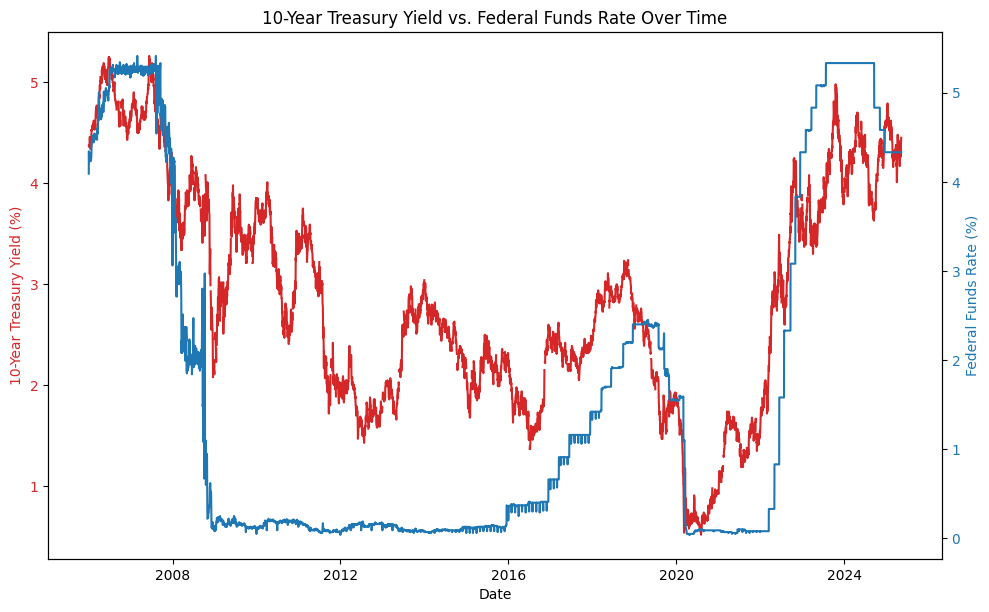

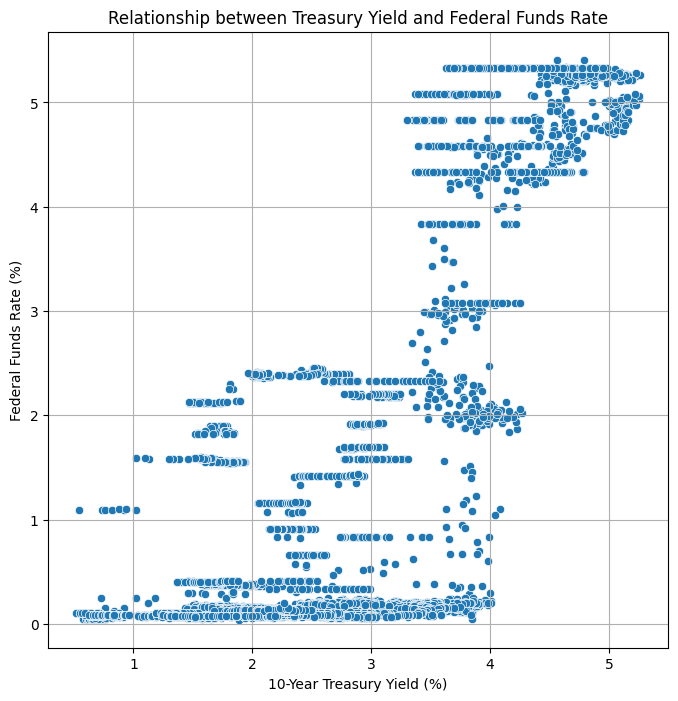

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'data' DataFrame is already available with 'Yield' and 'FedFundsRate' columns

# Time-series plot with two y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('10-Year Treasury Yield (%)', color=color)
ax1.plot(data.index, data['Yield'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Federal Funds Rate (%)', color=color)
ax2.plot(data.index, data['FedFundsRate'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('10-Year Treasury Yield vs. Federal Funds Rate Over Time')
plt.savefig('yields_vs_ffr_timeseries.png')

# Scatter plot to show the relationship directly
plt.figure(figsize=(8, 8))
sns.scatterplot(x='Yield', y='FedFundsRate', data=data)
plt.title('Relationship between Treasury Yield and Federal Funds Rate')
plt.xlabel('10-Year Treasury Yield (%)')
plt.ylabel('Federal Funds Rate (%)')
plt.grid(True)
plt.savefig('yields_vs_ffr_scatter.png')

print("Plots 'yields_vs_ffr_timeseries.png' and 'yields_vs_ffr_scatter.png' have been generated.")

In [6]:
speech_analysis_data = pd.read_sql("""
select chair,speaker, date, emphasis ,title 
from fed_speech_analysis fsa join
fed_speeches fs2 on fs2.id = fsa.speech_id
""",engine)

speech_data = speech_analysis_data[speech_analysis_data['chair'] == 'Jerome Powell']
speech_data['inflation'] = speech_analysis_data['emphasis'].apply(lambda x: x['inflation'])
speech_data['employment'] = speech_analysis_data['emphasis'].apply(lambda x: x['employment'])
speech_data['other'] = speech_analysis_data['emphasis'].apply(lambda x: x['other'])
speech_data['date']  =speech_analysis_data['date']
# 3. Merge Data
# Set speech dates as index
speech_data = speech_data.set_index('date')

# Merge with yield and federal funds rate
data = treasury_yield.join(ffr, how='outer')
all_data = data.join(speech_data, how='left')

#data = data.join(speech_data[['inflation', 'employment', 'other']], how='left')

# Forward-fill market data for non-trading days
all_data[['Yield', 'FedFundsRate']] = all_data[['Yield', 'FedFundsRate']].ffill()

# 4. Event-Study Setup
# Filter speech days
events = all_data.dropna(subset=['inflation', 'employment', 'other'])

/var/folders/tz/k1k21d6x7j1d90h0t6dqf5yc0000gn/T/ipykernel_88400/202405114.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  speech_data['inflation'] = speech_analysis_data['emphasis'].apply(lambda x: x['inflation'])
/var/folders/tz/k1k21d6x7j1d90h0t6dqf5yc0000gn/T/ipykernel_88400/202405114.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  speech_data['employment'] = speech_analysis_data['emphasis'].apply(lambda x: x['employment'])
/var/folders/tz/k1k21d6x7j1d90h0t6dqf5yc0000gn/T/ipykernel_88400/2024051

IndexError: single positional indexer is out-of-bounds

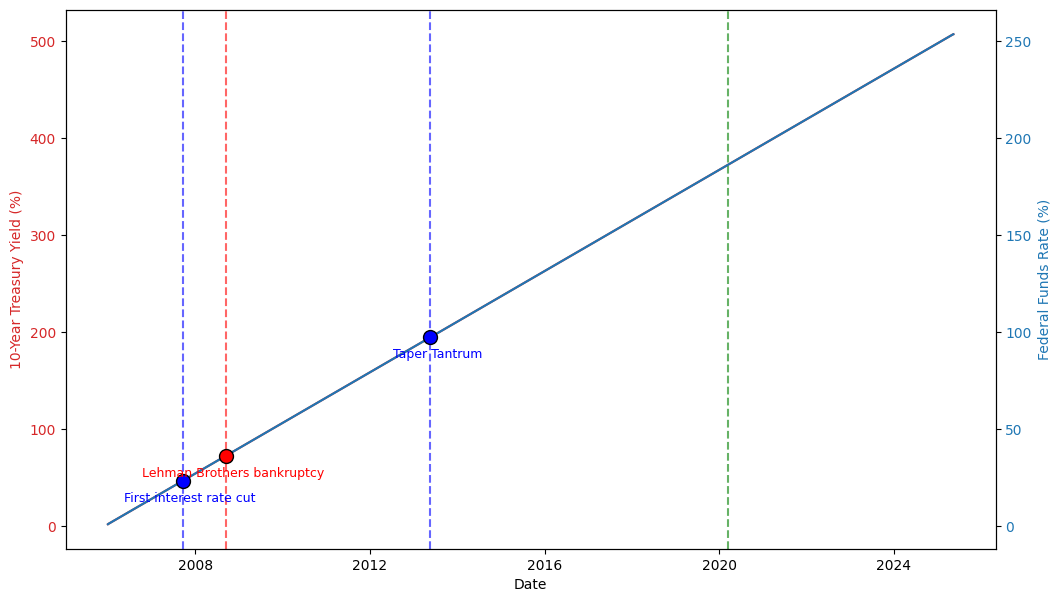

In [8]:
events

,Yield,FedFundsRate,chair,speaker,emphasis,title,inflation,employment,other
DATE,,,,,,,,,
2018-02-13,2.83,1.42,Jerome Powell,Chairman Jerome H. Powell,"{'inflation': 0.143, 'employment': 0.143, 'oth...",Remarks at the Ceremonial Swearing-in,0.143,0.143,0.714
2018-02-22,2.92,1.42,Jerome Powell,Vice Chairman for Supervision Randal K. Quarles,"{'inflation': 0.083, 'employment': 0.333, 'oth...",The U.S. Economy after the Global Financial Cr...,0.083,0.333,0.583
2018-02-26,2.86,1.42,Jerome Powell,Vice Chairman for Supervision Randal K. Quarles,"{'inflation': 0.273, 'employment': 0.273, 'oth...",An Assessment of the U.S. Economy,0.273,0.273,0.455
2018-02-26,2.86,1.42,Jerome Powell,Vice Chairman for Supervision Randal K. Quarles,"{'inflation': 0.0, 'employment': 0.077, 'other...",Brief Thoughts on the Financial Regulatory Sys...,0.000,0.077,0.923
2018-03-05,2.88,1.42,Jerome Powell,Vice Chairman for Supervision Randal K. Quarles,"{'inflation': 0.0, 'employment': 0.0, 'other':...",The Federal Reserve’s Regulatory Agenda for Fo...,0.000,0.000,1.000
...,...,...,...,...,...,...,...,...,...
2025-05-03,4.33,4.33,Jerome Powell,Governor Lisa D. Cook,"{'inflation': 0.0, 'employment': 0.333, 'other...",Four Guides for the Journey Ahead,0.000,0.333,0.667
2025-05-09,4.37,4.33,Jerome Powell,Governor Adriana D. Kugler,"{'inflation': 0.1, 'employment': 0.5, 'other':...",Assessing Maximum Employment,0.100,0.500,0.400
2025-05-09,4.37,4.33,Jerome Powell,Governor Christopher J. Waller,"{'inflation': 0.143, 'employment': 0.238, 'oth...","Thank You, John",0.143,0.238,0.619


In [42]:
events.to_csv('events.txt')

In [40]:
events.to_string('events.txt')

In [26]:
df = events

# Filter for Jerome Powell's speeches
#powell_df = df[df['speaker'] == 'Chairman Jerome H. Powell'].copy()
powell_df=df

In [27]:
df['speaker'] = df['speaker'].str[:20]

/var/folders/tz/k1k21d6x7j1d90h0t6dqf5yc0000gn/T/ipykernel_6349/2676260328.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['speaker'] = df['speaker'].str[:20]


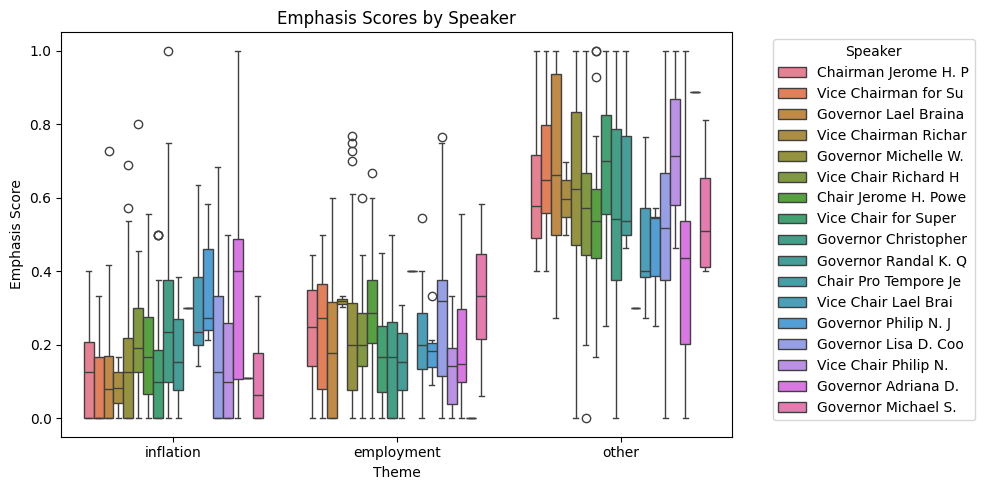

In [28]:

# 1. Box Plot of Emphasis Scores by Speaker
plt.figure(figsize=(10, 5))
df_melted = df.melt(id_vars=['speaker'], value_vars=['inflation', 'employment', 'other'],
                    var_name='Theme', value_name='Emphasis')
sns.boxplot(x='Theme', y='Emphasis', hue='speaker', data=df_melted)
plt.title('Emphasis Scores by Speaker')
plt.xlabel('Theme')
plt.ylabel('Emphasis Score')
plt.legend(title='Speaker', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('emphasis_by_speaker.png')
plt.show()
plt.close()

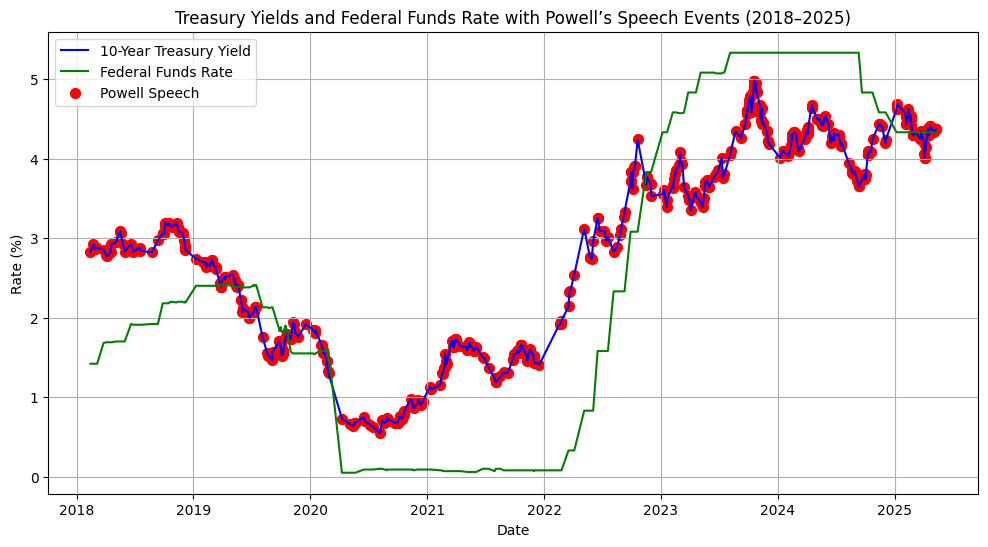

In [29]:

# 2. Time Series of Yields and Fed Funds Rate with Speech Events
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Yield'], label='10-Year Treasury Yield', color='blue')
plt.plot(df.index, df['FedFundsRate'], label='Federal Funds Rate', color='green')
# Mark Powell's speech dates
plt.scatter(powell_df.index, powell_df['Yield'], color='red', marker='o', label='Powell Speech', s=50)
plt.title('Treasury Yields and Federal Funds Rate with Powell’s Speech Events (2018–2025)')
plt.xlabel('Date')
plt.ylabel('Rate (%)')
plt.legend()
plt.grid(True)
plt.savefig('yields_speech_events.png')
plt.show()

plt.close()

/var/folders/tz/k1k21d6x7j1d90h0t6dqf5yc0000gn/T/ipykernel_6349/2851066900.py:2: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_emphasis = powell_df.resample('Y')[['inflation', 'employment', 'other']].mean()


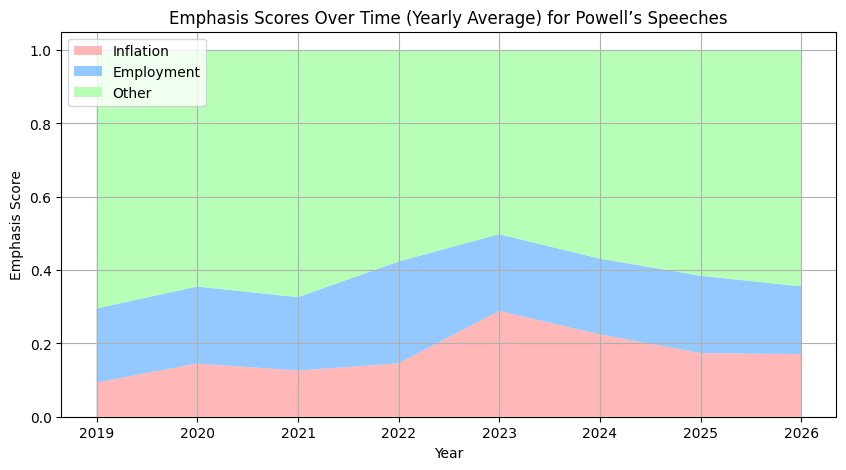

In [30]:

# 3. Stacked Area Chart of Emphasis Scores Over Time (Yearly Average)
yearly_emphasis = powell_df.resample('Y')[['inflation', 'employment', 'other']].mean()
plt.figure(figsize=(10, 5))
plt.stackplot(yearly_emphasis.index, yearly_emphasis['inflation'], yearly_emphasis['employment'], yearly_emphasis['other'],
              labels=['Inflation', 'Employment', 'Other'], colors=['#ff9999', '#66b3ff', '#99ff99'], alpha=0.7)
plt.title('Emphasis Scores Over Time (Yearly Average) for Powell’s Speeches')
plt.xlabel('Year')
plt.ylabel('Emphasis Score')
plt.legend(loc='upper left')
plt.grid(True)
plt.savefig('emphasis_stacked_area.png')
plt.show()
plt.close()


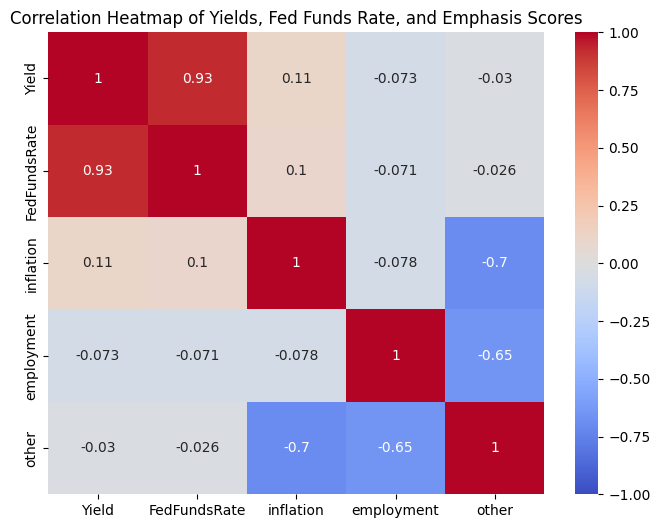

In [31]:

# 4. Correlation Heatmap of Numeric Variables
plt.figure(figsize=(8, 6))
correlation_matrix = df[['Yield', 'FedFundsRate', 'inflation', 'employment', 'other']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap of Yields, Fed Funds Rate, and Emphasis Scores')
plt.savefig('correlation_heatmap.png')
plt.show()
plt.close()

/var/folders/tz/k1k21d6x7j1d90h0t6dqf5yc0000gn/T/ipykernel_6349/1217361369.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  powell_df['year'] = powell_df.index.year


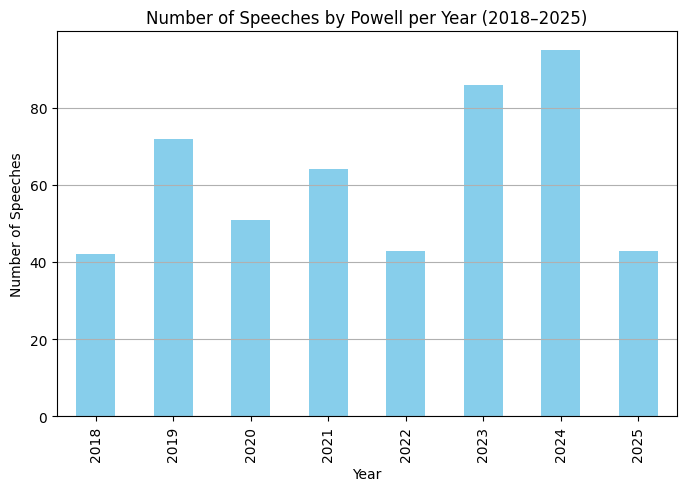

In [32]:
# 5. Speech Frequency by Year
powell_df['year'] = powell_df.index.year
speech_counts = powell_df['year'].value_counts().sort_index()
plt.figure(figsize=(8, 5))
speech_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Speeches by Powell per Year (2018–2025)')
plt.xlabel('Year')
plt.ylabel('Number of Speeches')
plt.grid(True, axis='y')
plt.savefig('speech_frequency.png')
plt.show()
plt.close()

In [33]:
# 6. Summary Statistics (for reference in paper)
stats = powell_df[['inflation', 'employment', 'other']].describe()
stats_summary = stats.loc[['mean', 'std', 'min', 'max']].T
stats_summary.to_csv('emphasis_stats.csv', index=True)
plt.show()
print("Summary Statistics for Powell's Speeches:")
print(stats_summary)

Summary Statistics for Powell's Speeches:
                mean       std  min    max
inflation   0.172800  0.179123  0.0  1.000
employment  0.214294  0.168456  0.0  0.769
other       0.612895  0.236115  0.0  1.000
